# Automatic recognition and classification of observational sentences in "Astronomia nova" using refined NER model

Gerd Graßhoff$^{(1,2)}$, Mohammad Yeghaneh$^{(2)}$

1: Max-Planck-Institute for the History of Science, Berlin

2: Humboldt University, Berlin

Date: October 2019

In [1]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2
#import utility_01
#from utility_01 import *
from sklearn.metrics import roc_curve ,roc_auc_score ,precision_recall_curve,auc
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot

In [2]:
options = {"compact": True, "bg": "#09a3d5",
           "color": "white", "font": "Source Sans Pro","collapse_phrases":False}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('max_colwidth', 260)


##  Resources

### Import resources

In [4]:
df=pd.read_json('../data/dfObsV03A02.json');
df=df.sort_index();


In [8]:
df.head()

,sents,chapter,aso,entities,fner,label
0,Chapter 1,1,{'act': 'Chapter'},[],"[0, 0, 0]",0
1,"On the distinction between the first motion and the second or proper motions; and in the proper motions, between the first and the second inequality.",1,{'act': 'On'},[],"[0, 0, 0]",0
2,The testimony of the ages confirms that the motions of the planets are orbicular.,1,"{'act': 'confirms', 'subject': 'testimony'}",[],"[0, 0, 0]",0
3,"Reason, having borrowed from experience, immediately presumes this: that their gyrations are perfect circles.",1,"{'act': 'presumes', 'subject': 'reason', 'obj': 'this: that their gyrations are perfect circles'}",[],"[0, 0, 0]",0
4,"For among figures it is circles, and among bodies the heavens, that are considered the most perfect.",1,{'act': 'considered'},[],"[0, 0, 0]",0


In [9]:
df.tail()

,sents,chapter,aso,entities,fner,label
6694,"To find the position of Mars at opposition, Kepler computed the angular distance that Mars and Earth—now substituting the place of the Sun—moved during 17 hours 20 minutes; Mars moved eastward about 16' 20"" and the Sun westward about 42' 18"".",appendix b,"{'act': 'moved', 'subject': 'mars'}","[[Mars, PLAN], [opposition, ASTR], [Mars, PLAN], [Earth, PLAN], [Sun, PLAN], [17 hours 20 minutes, TIME], [Mars, PLAN], [eastward, ASTR], [16' 20"", LONG], [Sun, PLAN], [42' 18"", LONG]]","[0, 1, 1]",0
6695,"Accordingly, Kepler determined the longitude of Mars at opposition to be 198° 37' 50"" from which he subtracted about 39"" in order to correct Mars's orbit; he got 198° 37' 10"" (18° 37' 10"" Libra).",appendix b,"{'act': 'got', 'subject': 'he', 'obj': '' 10'}","[[longitude, ASTR], [Mars, PLAN], [opposition, ASTR], [198° 37' 50"", LONG], [Mars, PLAN], [orbit, ASTR], [198° 37' 10"", LONG], [18° 37' 10"" Libra, LONG]]","[0, 0, 1]",0
6696,The Sun moved westward and its longitude decreased from the time of observation to its position opposite to Mars.,appendix b,"{'act': 'moved', 'subject': 'sun'}","[[Sun, PLAN], [longitude, ASTR], [observation, ASTR], [Mars, PLAN]]","[0, 0, 0]",0
6697,"Therefore, the time of opposition is 17 hours 20 minutes before March 29, at 21:43, the time when the observation was made.",appendix b,"{'act': 'is', 'subject': 'time'}","[[opposition, ASTR], [17 hours 20, TIME], [March 29, DATE], [observation, ASTR]]","[1, 1, 0]",0
6698,"Kepler determined the time of opposition on March 28, 4h 23m AM, old style.",appendix b,"{'act': 'determined', 'subject': 'kepler', 'obj': 'the time of opposition on March 28'}","[[opposition, ASTR], [March 28, DATE], [4h 23m, TIME]]","[1, 1, 0]",0


# Distribution of Samples 

In [10]:
from collections import Counter
y=np.array(list(df["label"]))
category=Counter(y)
count=dict(category)

In [11]:
count

{0: 6625, 1: 74}

Text(0.5, 1.0, 'Distribution of samples over different classes')

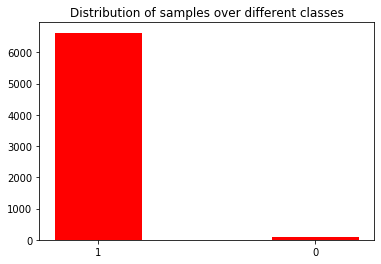

In [12]:
plt.bar(list(count.keys()),count.values(),color="r",width=.4,tick_label=["1","0"])
plt.title("Distribution of samples over different classes")


In [13]:
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import SGDClassifier, LogisticRegression,LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from xgboost import XGBClassifier

## Models

In [14]:
#-Random Forest Classifier
trial= Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('clf', RandomForestClassifier(n_estimators=1000, random_state=0 ))])
####################################################
## 01-Random Forest Classifier with weights
class_weight = dict({0:.0069, 1:700000})
trial_01= Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('clf', RandomForestClassifier(n_estimators=1000, random_state=0 ,class_weight=class_weight))])
vec=TfidfVectorizer()
clf= SGDClassifier()
trial_05=Pipeline([("vect",vec),("clf",clf)])
#####################################################
## 02-XGBClassifier
#trial_02 = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     #('clf', XGBClassifier())])


In [15]:
X=list(df["sents"])
y=np.array(list(df["label"]))

In [16]:
type(df["entities"][0])

list

In [17]:
X,y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
X,y, test_size=0.25, random_state=42)  

## 1- Random Forest 

In [18]:
trial.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...ators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [19]:
y_pred=trial.predict(X_test)

In [20]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
cr=classification_report(y_test,y_pred)
print(cr)
#Color_Confusion_Matrix(y, y_test, y_pred)


[[1660    0]
 [  15    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1660
           1       0.00      0.00      0.00        15

   micro avg       0.99      0.99      0.99      1675
   macro avg       0.50      0.50      0.50      1675
weighted avg       0.98      0.99      0.99      1675



In [21]:
cross_validation_accuracy(trial,X,y,cv=3)

[0.98880931 0.9888043  0.98924731]
Accuracy of : 0.989 ± 0.000


In [22]:
y_pred = cross_val_predict(trial, X, y, cv=3)
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
print(cm)
#Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6625
           1       0.00      0.00      0.00        74

   micro avg       0.99      0.99      0.99      6699
   macro avg       0.49      0.50      0.50      6699
weighted avg       0.98      0.99      0.98      6699

[[6625   74]
 [   0    0]]


In [23]:
precision, recall, thresholds = precision_recall_curve(y,y_pred)  
auc_score = auc(recall, precision)


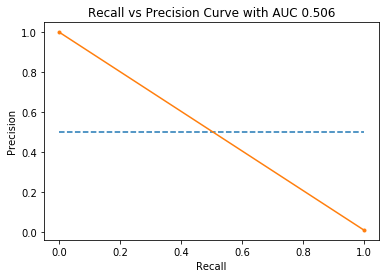

AUC: 0.506


In [24]:
plot_pr(recall, precision)

## 1-SGD

In [25]:
trial_05.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [26]:
y_pred=trial_05.predict(X_test)

In [27]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
cr=classification_report(y_test,y_pred)
print(cr)
#Color_Confusion_Matrix(y, y_test, y_pred)


[[1657    3]
 [   8    7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1660
           1       0.70      0.47      0.56        15

   micro avg       0.99      0.99      0.99      1675
   macro avg       0.85      0.73      0.78      1675
weighted avg       0.99      0.99      0.99      1675



In [28]:
cross_validation_accuracy(trial_05,X,y,cv=3)

[0.99239033 0.99238692 0.99238351]
Accuracy of : 0.992 ± 0.000


In [29]:
y_pred = cross_val_predict(trial_05, X, y, cv=3)

cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
#Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6625
           1       0.84      0.49      0.62        74

   micro avg       0.99      0.99      0.99      6699
   macro avg       0.92      0.74      0.81      6699
weighted avg       0.99      0.99      0.99      6699



In [30]:
print(cm)

[[6618   38]
 [   7   36]]


In [31]:
precision, recall, thresholds = precision_recall_curve(y,y_pred)  
auc_score = auc(recall, precision)


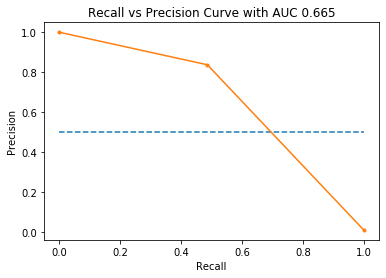

AUC: 0.665


In [32]:
plot_pr(recall, precision)

In [33]:
from eli5 import show_weights
show_weights(trial_05, top=30)

Weight?,Feature
+3.153,30m
+2.644,12h
+2.208,7h
+2.164,january
+2.108,on
+1.800,11h
+1.755,8h
+1.723,october
+1.707,9h
+1.702,20m


In [34]:
index_0=list(np.where(y==0))
index_1=list(np.where(y==1))
idx_0=index_0[0].tolist();
idx_1=index_1[0].tolist();

In [35]:
import eli5
eli5.show_prediction(clf, X[idx_1[5]],vec=vec)

In [36]:
eli5.show_prediction(clf, X[idx_1[7]],vec=vec)

In [37]:
eli5.show_prediction(clf, X[idx_0[0]],vec=vec)

In [38]:
eli5.show_prediction(clf, X[idx_0[1]],vec=vec)

# Parameter tununed SGD

In [60]:
param_grid_01= {
    'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e-1, 1e2, 1e3], # learning rate
    'clf__max_iter': [500,1000,2000,3000], # number of epochs
    'clf__penalty': ['l2','l1','elasticnet'],
    'clf__loss': ['hinge','log'],
    'clf__n_jobs': [-1],
     'clf__tol': [1e-4, 1e-3, 1e-2,1e-1]
}
trial_05_01 = GridSearchCV(trial_05, param_grid=param_grid_01, cv=5, n_jobs=-1, verbose=2)

[autoreload of utility_01 failed: Traceback (most recent call last):
  File "c:\users\moha\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\moha\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 434, in superreload
    module = reload(module)
  File "C:\Users\moha\Anaconda3\envs\envc\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\moha\Anaconda3\envs\envc\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "C:\Projects_28_06\notebooks\yeghaneh\BZML_OCT\notebooks\utility_01.py", line 43, in <module>
    df_corr = someDataFrame.corr()
NameError: name 'someDataFrame' is not defined
]


In [40]:
trial_05_01.fit(X_train,y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 0.1, 100.0, 1000.0], 'clf__max_iter': [500, 1000, 2000, 3000], 'clf__penalty': ['l2', 'l1', 'elasticnet'], 'clf__loss': ['hinge', 'log'], 'clf__n_jobs': [-1], 'clf__tol': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [41]:
y_pred=trial_05_01.predict(X_test)

In [42]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
cr=classification_report(y_test,y_pred)
print(cr)
#Color_Confusion_Matrix(y, y_test, y_pred)

[[1656    4]
 [   6    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1660
           1       0.69      0.60      0.64        15

   micro avg       0.99      0.99      0.99      1675
   macro avg       0.84      0.80      0.82      1675
weighted avg       0.99      0.99      0.99      1675



In [43]:
cross_validation_accuracy(trial_05_01,X,y,cv=3)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.8min finished


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.7min finished


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.8min finished


[0.99328559 0.99283475 0.99283154]
Accuracy of : 0.993 ± 0.000


In [44]:
y_pred = cross_val_predict(trial_05_01, X, y, cv=3)

cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
#Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.8min finished


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.7min finished


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  2.8min finished


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6625
           1       0.70      0.47      0.56        74

   micro avg       0.99      0.99      0.99      6699
   macro avg       0.85      0.74      0.78      6699
weighted avg       0.99      0.99      0.99      6699



In [45]:
print(cm)

[[6610   39]
 [  15   35]]


## Unsing SGD Undersampled Model


In [93]:
import pickle
Pkl_Filename = "Pickle_SGD_RESAMPLED_Model.pkl"  
with open(Pkl_Filename, 'rb') as file:  
       SGD_RESAMPLED_Model = pickle.load(file)

In [94]:
y_pred=SGD_RESAMPLED_Model.predict(X)

In [95]:
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
#Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      6625
           1       0.12      1.00      0.22        74

   micro avg       0.92      0.92      0.92      6699
   macro avg       0.56      0.96      0.59      6699
weighted avg       0.99      0.92      0.95      6699



In [96]:
print(cm)

[[6104    0]
 [ 521   74]]


# Ensemble Model (Downsampled SGD + SGD)

In [97]:
from sklearn.ensemble import VotingClassifier#create a dictionary of our models
estimators=[("trial",trial), ("resampled",  SGD_RESAMPLED_Model)]#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [98]:
ensemble.fit(X_train,y_train)

VotingClassifier(estimators=[('trial', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), ...tate=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [99]:
y_pred=ensemble.predict(X_test)

In [100]:
cr=classification_report(y_test,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y_test)
#Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1660
           1       0.00      0.00      0.00        15

   micro avg       0.99      0.99      0.99      1675
   macro avg       0.50      0.50      0.50      1675
weighted avg       0.98      0.99      0.99      1675



In [101]:
print(cm)

[[1660   15]
 [   0    0]]


In [102]:
y_pred = cross_val_predict(ensemble, X, y, cv=3)
cr=classification_report(y,y_pred)
print(cr)
cm = confusion_matrix(y_pred,y)
#Color_Confusion_Matrix(y=y,y_test=y,y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6625
           1       0.00      0.00      0.00        74

   micro avg       0.99      0.99      0.99      6699
   macro avg       0.49      0.50      0.50      6699
weighted avg       0.98      0.99      0.98      6699



In [103]:
print(cm)

[[6625   74]
 [   0    0]]


In [104]:
precision, recall, thresholds = precision_recall_curve(y,y_pred)  
auc_score = auc(recall, precision)


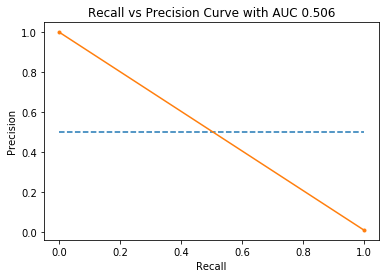

AUC: 0.506


In [105]:
plot_pr(recall, precision)